In [29]:
pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

In [3]:
import tqdm

## Load documents with IDs

In [4]:
import requests 
import pandas as pd

github_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/04-monitoring/data/results-gpt4o-mini.csv'
url = f'{github_url}?raw=1'
df = pd.read_csv(url)

We will use only the first 300 documents:

In [5]:
df = df.iloc[:300]

In [6]:
df.describe()

,answer_llm,answer_orig,document,question,course
count,300,300,300,300,300
unique,300,60,60,300,1
top,If the file download fails when using the requ...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,What does the code using the requests library ...,machine-learning-zoomcamp
freq,1,5,5,1,300


## Get the Embeddings

In [7]:
model_name = 'multi-qa-mpnet-base-dot-v1'

from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name)

You try to use a model that was created with version 3.0.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





###### Create the embeddings for the first LLM answer:

In [8]:
answer_llm = df.iloc[0].answer_llm

In [9]:
embedding_answer_one = embedding_model.encode(answer_llm)

In [10]:
len(embedding_answer_one)

768

#### First Value, at index 0

In [11]:
embedding_answer_one[0]

np.float32(-0.42244655)

#### Q2. Computing the dot product

Now for each answer pair, let's create embeddings and compute dot product between them

We will put the results (scores) into the evaluations list

What's the 75% percentile of the score?

In [12]:
# Create a list to store the scores
evaluations = []

# Loop through each row in the dataframe
for index, row in df.iterrows():
    # Get the answer pair
    answer_llm = row['answer_llm']
    answer_orig = row['answer_orig']

    # Create embeddings for each answer
    v_llm = embedding_model.encode(answer_llm)
    v_orig = embedding_model.encode(answer_orig)
    score = v_llm.dot(v_orig)
    
    evaluations.append(score.item())

#### What's the 75% percentile of the score?

In [13]:
percentile_75 = np.percentile(evaluations, 75)

print(f'75% percentile of the scores: {percentile_75:.4f}')

75% percentile of the scores: 31.6743


#### Q3. Computing the cosine

From Q2, we can see that the results are not within the [0, 1] range. It's because the vectors coming from this model are not normalized.

So we need to normalize them.

To do it, we

Compute the norm of a vector
Divide each element by this norm
So, for vector v, it'll be v / ||v||

In numpy, this is how you do it:

In [14]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = embedding_model.encode(answer_llm)
    v_orig = embedding_model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [15]:
similarity = []
for index, row in df.iterrows():
    sim = compute_similarity(row)
    similarity.append(sim)

In [16]:
if evaluations == similarity:
    print("Lists are the same")
else:
    print("Lists are different")

Lists are the same


#### Let's normalize our vectors and then compute cosine similarity

In [17]:
def compute_similarity_norm(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = embedding_model.encode(answer_llm)
    v_orig = embedding_model.encode(answer_orig)
    
    # Normalize the vectors
    v_llm_norm = v_llm / np.linalg.norm(v_llm)
    v_orig_norm = v_orig / np.linalg.norm(v_orig)
    
    # Calculate the dot product using the normalized vectors
    return v_llm_norm.dot(v_orig_norm)

In [18]:
similarity_norm = []
for index, row in df.iterrows():
    sim = compute_similarity_norm(row)
    similarity_norm.append(sim)

In [19]:
df['cosine'] = similarity_norm
df['cosine'].describe()

count    300.000000
mean       0.728393
std        0.157755
min        0.125357
25%        0.651273
50%        0.763761
75%        0.836235
max        0.958796
Name: cosine, dtype: float64

In [22]:
print("75 percentile is 0.836235")

75 percentile is 0.836235


In [32]:
import seaborn as sns

/tmp/ipykernel_46551/3710624747.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

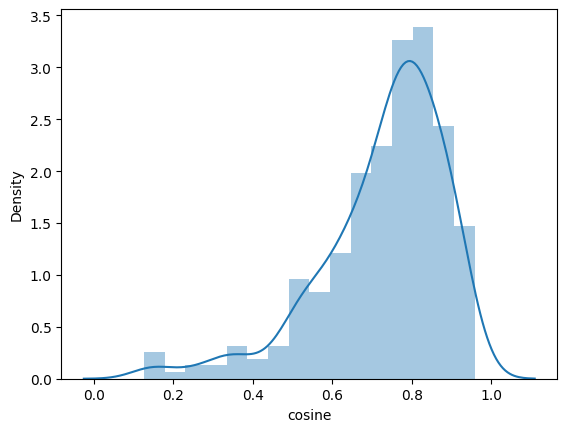

In [33]:
sns.distplot(df['cosine'])

#### Q4. Rouge
Now we will explore an alternative metric - the ROUGE score.

This is a set of metrics that compares two answers based on the overlap of n-grams, word sequences, and word pairs.

It can give a more nuanced view of text similarity than just cosine similarity alone.

We don't need to implement it ourselves, there's a python package for it:

In [ ]:
pip install rouge

Let's compute the ROUGE score between the answers at the index 10 of our dataframe (doc_id=5170565b)

In [36]:
df.iloc[10]

answer_llm     Yes, all sessions are recorded, so if you miss...
answer_orig    Everything is recorded, so you won’t miss anyt...
document                                                5170565b
question                    Are sessions recorded if I miss one?
course                                 machine-learning-zoomcamp
cosine                                                  0.777956
Name: 10, dtype: object

In [40]:
from rouge import Rouge
rouge_scorer = Rouge()

scores = rouge_scorer.get_scores(df.loc[10, 'answer_llm'], df.loc[10, 'answer_orig'])[0]

In [47]:
scores

{'rouge-1': {'r': 0.45454545454545453,
  'p': 0.45454545454545453,
  'f': 0.45454544954545456},
 'rouge-2': {'r': 0.21621621621621623,
  'p': 0.21621621621621623,
  'f': 0.21621621121621637},
 'rouge-l': {'r': 0.3939393939393939,
  'p': 0.3939393939393939,
  'f': 0.393939388939394}}

##### There are three scores: rouge-1, rouge-2 and rouge-l, and precision, recall and F1 score for each.

rouge-1 - the overlap of unigrams,

rouge-2 - bigrams,

rouge-l - the longest common subsequence

What's the F score for rouge-1?

In [42]:
f_score_rouge_1 = scores['rouge-1']['f']
print(f_score_rouge_1)

0.45454544954545456


#### Q5: Let's compute the average F-score between rouge-1, rouge-2 and rouge-l for the same record from Q4

In [43]:
average_f_score = (scores['rouge-1']['f'] + scores['rouge-2']['f'] + scores['rouge-l']['f']) / 3
print("Average F-score:", average_f_score)

Average F-score: 0.35490034990035496


#### Q6. Average rouge score for all the data points

###### Now let's compute the F-score for all the records and create a dataframe from them.

###### What's the average F-score in rouge_2 across all the records?

In [48]:
rouge_1_f = []
rouge_2_f = []
rouge_l_f = []

In [51]:
for index, row in df.iterrows():
    scores = rouge_scorer.get_scores(df.loc[index, 'answer_llm'], df.loc[index, 'answer_orig'])[0]
    score_1_f = scores['rouge-1']['f']
    score_2_f = scores['rouge-2']['f']
    score_l_f = scores['rouge-l']['f']
    rouge_1_f.append(score_1_f)
    rouge_2_f.append(score_2_f)
    rouge_l_f.append(score_l_f)    

In [53]:
rouge_1_f[10]

0.45454544954545456

In [54]:
rouge_2_f[10]

0.21621621121621637

In [55]:
rouge_l_f[10]

0.393939388939394

In [57]:
df['rouge_1_f'] = rouge_1_f
df['rouge_2_f'] = rouge_2_f
df['rouge_l_f'] = rouge_l_f

In [59]:
df.describe()

,cosine,rouge_1_f,rouge_2_f,rouge_l_f
count,300.000000,300.000000,300.000000,300.000000
mean,0.728393,0.378844,0.206965,0.353807
std,0.157755,0.165977,0.153550,0.162965
min,0.125357,0.000000,0.000000,0.000000
25%,0.651273,0.261625,0.097809,0.228032
50%,0.763761,0.378762,0.178671,0.337792
75%,0.836235,0.479281,0.286181,0.451613
max,0.958796,0.850000,0.739130,0.850000


In [61]:
print(df['rouge_2_f'].mean())

0.20696501983423318
